##### Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read the dataset & do some mungings

In [2]:
df = pd.read_csv('random_sample.csv')

In [3]:
# Use the trip start timestamp as the index of the dataframe
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df.index = df['trip_start_timestamp'].dt.tz_convert('America/Chicago')

In [4]:
# Drop the pickup and dropoff location columns as they contain redundant information
# Drop the trip start and trip end timestamp columns
df = df.drop(columns = ['pickup_location', 'dropoff_location'], axis=1)
df = df.drop(columns = ['trip_start_timestamp', 'trip_end_timestamp'], axis=1)

In [5]:
df.isna().sum()

unique_key                    0
taxi_id                       0
trip_seconds                  0
trip_miles                    0
pickup_census_tract           0
dropoff_census_tract          0
pickup_community_area         0
dropoff_community_area        0
fare                          0
tips                          0
tolls                     13217
extras                        0
trip_total                    0
payment_type                  0
company                       0
pickup_latitude               0
pickup_longitude              0
dropoff_latitude              0
dropoff_longitude             0
dtype: int64

In [6]:
# Fill the missing values of tolls with 0
df = df.fillna(0)

#### Create new columns for the analysis

In [7]:
# The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. 
# The unit of measurement is miles.

def haversine(lon1, lat1, lon2, lat2):
    
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of earth in kilometers is 6371
    km = 6371.0088 * c
    miles_geo_distance = km * 0.62137119223733  # Convert to miles
    miles_geo_distance = round(miles_geo_distance,2)
    return miles_geo_distance

vec_haversine = np.vectorize(haversine)

In [8]:
# Extracting 'hour of day', 'day of week', 'month of year', and a boolean for 'weekend'

df['hour_of_day'] = df.index.hour
df['day_of_week'] = df.index.strftime('%A')   # Monday to Sunday
df['month_of_year'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)  # 1 for weekend, 0 for not

In [9]:
df['miles/seconds'] = df['trip_miles'] / df['trip_seconds']

In [10]:
df['fare/miles'] = df['fare'] / df['trip_miles']

In [11]:
df['fare/seconds'] = df['fare'] / df['trip_seconds']

In [12]:
df['earned'] = df['fare'] + df['extras'] + df['tips']

In [13]:
df['tips/fare'] = df['tips'] / df['fare']

In [14]:
df['gc_distance'] = vec_haversine(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [15]:
# Community areas are mapped to 10 category areas of the chicago city for easier analysis
community_area_mapping = {
    'Downtown/Central': [8, 32, 33],
    'North Side': [5, 6, 7, 21, 22],
    'West Side': [23, 24, 25, 26, 27, 28, 29, 30, 31],
    'Northwest Side': [15, 16, 17, 18, 19, 20],
    "O'Hare Airport": [76],
    'Midway Airport': [56],
    'South Side': [1, 9, 13, 36, 40, 44, 48, 52, 57, 61, 65, 69, 73],
    'Far North Side': [2, 10, 14, 37, 41, 45, 49, 53, 58, 62, 66, 70, 74],
    'Far South Side': [3, 11, 34, 38, 42, 46, 50, 54, 59, 63, 67, 71, 75],
    'Southwest Side': [4, 12, 35, 39, 43, 47, 51, 55, 60, 64, 68, 72, 77]
}


# Invert the mapping to have a dictionary of community area to category
area_to_category = {area_number: category for category, areas in community_area_mapping.items() for area_number in areas}

# Apply the mapping to the pickup and dropoff community areas
df['pickup_category_area'] = df['pickup_community_area'].map(area_to_category)
df['dropoff_category_area'] = df['dropoff_community_area'].map(area_to_category)


In [16]:
# integer label coding for unique_key and taxi_id (easiers reference and less memory)
df['unique_key_int'] = pd.factorize(df['unique_key'])[0]
df['taxi_id_int'] = pd.factorize(df['taxi_id'])[0]
df = df.drop(['unique_key', 'taxi_id'], axis = 1)

In [17]:
# save the updated dataframe as csv for ML model
df.to_csv('df_random_sample.csv')

### Market Segmentation

In [18]:
# For the sake of beverity, we will only use temporal and spatial market segmentations for the rest of the analysis. Here are some other market segmentations that can be used for further analysis:
# 1. Fare segmentation: segment customers based on the fare they paid
# 2. Distance segmentation: segment customers based on the distance they travelled
# 3. Payment type segmentation: segment customers based on the payment type they used
# 4. K means clustering: segment customers to statistical clusters

## Statistical Analysis

### Impacts of numerical values on taxi fares and trips

In [19]:
# The impact of numercial values on the taxi fares and tips are analyzed using pearson correlation coefficient

In [20]:
df[['trip_seconds','trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'miles/seconds', 'gc_distance' ]].corr()['fare']
# It seems that the fare is mostly impacted by the following independent variables: the trip seconds, trip miles, and absolute distance between the pickup and dropoff locations (greater circle distance)

trip_seconds     0.513428
trip_miles       0.664957
fare             1.000000
tips             0.484949
tolls            0.005251
extras           0.382145
trip_total       0.985850
miles/seconds    0.039874
gc_distance      0.674956
Name: fare, dtype: float64

In [21]:
df[['trip_seconds','trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'miles/seconds', 'gc_distance', 'fare/miles', 'fare/seconds']].corr()['fare/miles']
# Normalized fare per mile is almost independent of the other independent variables

trip_seconds    -0.010604
trip_miles      -0.033771
fare             0.601104
tips            -0.002954
tolls           -0.000299
extras          -0.006673
trip_total       0.529854
miles/seconds   -0.003210
gc_distance     -0.015567
fare/miles       1.000000
fare/seconds     0.425098
Name: fare/miles, dtype: float64

In [22]:
df[['trip_seconds','trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'miles/seconds', 'gc_distance', 'fare/miles', 'fare/seconds' ]].corr()['fare/seconds']
# Normalized fare per seconds is almost independent of the other independent variables

trip_seconds    -0.023542
trip_miles       0.013940
fare             0.141740
tips             0.048001
tolls           -0.000047
extras           0.064953
trip_total       0.137745
miles/seconds    0.378284
gc_distance     -0.004335
fare/miles       0.425098
fare/seconds     1.000000
Name: fare/seconds, dtype: float64

In [23]:
df[['trip_seconds','trip_miles', 'fare', 'tips', 'tolls', 'trip_total', 'miles/seconds', 'gc_distance', 'fare/miles', 'fare/seconds', 'tips/fare' ]].corr()['tips/fare']
# Tip percentage is impacted by non of the numerical independent variables

trip_seconds    -0.009125
trip_miles       0.018251
fare             0.006592
tips             0.517593
tolls           -0.001875
trip_total       0.088781
miles/seconds    0.000451
gc_distance      0.028508
fare/miles      -0.006990
fare/seconds     0.002126
tips/fare        1.000000
Name: tips/fare, dtype: float64

In [24]:
# Insights:
# The fare is mostly impacted by the following independent variables: the trip seconds, trip miles, and absolute distance between the pickup and dropoff locations (greater circle distance)
# Normilized fare per mile and per second are almost independent of the other independent variables
# Tip percentage is impacted by non of the numerical independent variables

In [25]:
# To investigate the impact of the categorical variables on the number of trips, fare and tips, visualizations are used. Here, temporal (hour of day) and spatial (pickup and dropoff community areas) variables are analyzed.
# Furthur analysis based on the day of week and month of year is not included here for the sake of brevity.

### Analysis based on number of trips

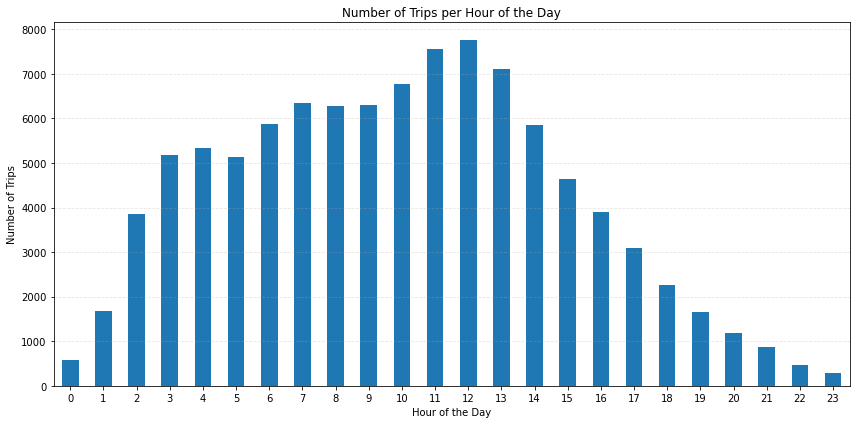

In [26]:
# Plot the distribution of the trips per hour of the day
hourly_trip_counts = df.groupby('hour_of_day').size()

plt.figure(figsize=(12, 6))
hourly_trip_counts.plot(kind='bar')
plt.title('Number of Trips per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

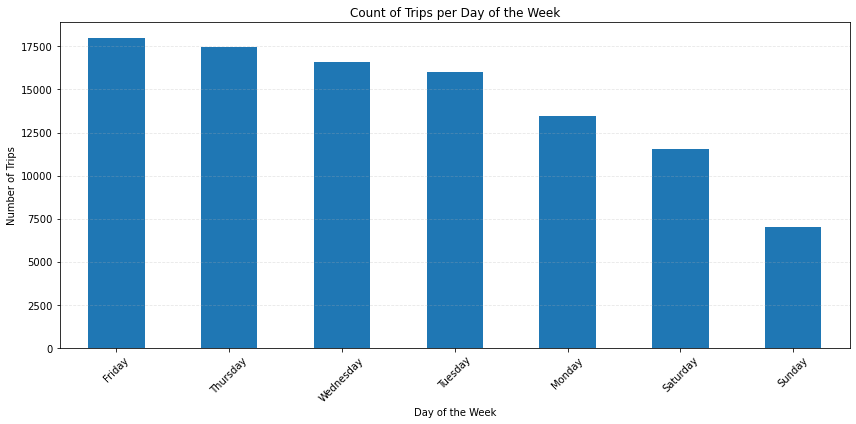

In [27]:
# Plot the distribution of the trips per day of the week
day_of_week_trip_counts = df.groupby('day_of_week').size()

plt.figure(figsize=(12, 6))
day_of_week_trip_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Count of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

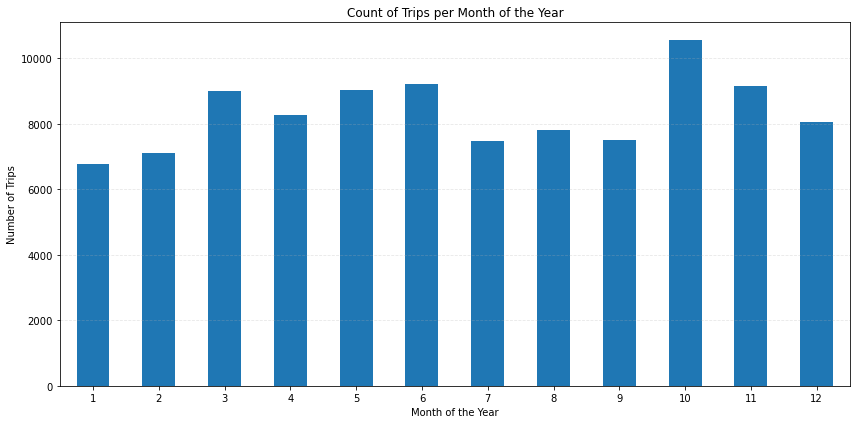

In [28]:
# Plot the distribution of the trips per month of the year
month_of_year_trip_counts = df.groupby('month_of_year').size()

plt.figure(figsize=(12, 6))
month_of_year_trip_counts.plot(kind='bar')
plt.title('Count of Trips per Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

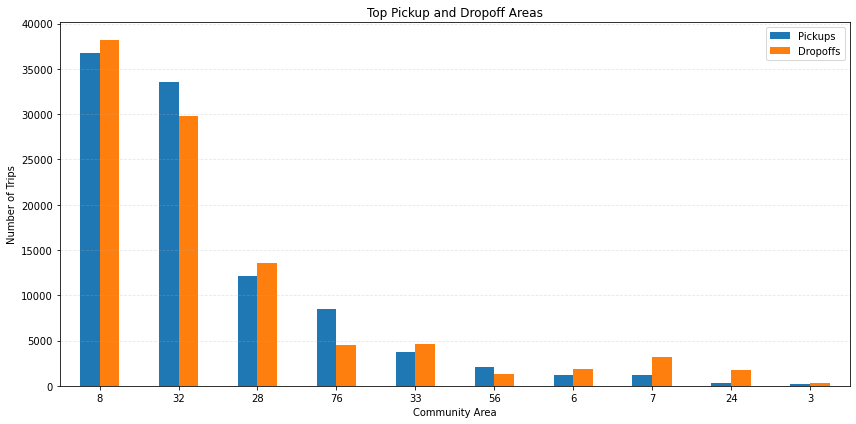

In [29]:
# Plot top 10 pickup and dropoff community areas 

# Create a combined DataFrame for the top areas
top_areas = pd.DataFrame({
    'Pickups': df['pickup_community_area'].value_counts().head(10),
    'Dropoffs': df['dropoff_community_area'].value_counts().head(10)
})

# Since we want to display both pickups and dropoffs in one plot, we'll sort the data to make it clearer
top_areas_sorted = top_areas.sort_values(by=['Pickups', 'Dropoffs'], ascending=False)

# Now let's create a vertical bar plot with both pickup and dropoff distributions
plt.rcParams['figure.figsize'] = [12, 6] 
top_areas_sorted.plot(kind='bar')
plt.title('Top Pickup and Dropoff Areas')
plt.xlabel('Community Area')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [69]:
top_pickup_df.groupby(['pickup_community_area', top_pickup_df.index.hour]).size()

pickup_community_area  trip_start_timestamp
3                      1                         3
                       2                         9
                       3                        16
                       4                        22
                       5                        10
                                              ... 
76                     19                      125
                       20                       51
                       21                       14
                       22                        5
                       23                       18
Length: 234, dtype: int64

In [73]:
top_pickup_df.groupby(['pickup_community_area', top_pickup_df.index.hour]).size().unstack(level=-1).index

Int64Index([3, 6, 7, 8, 24, 28, 32, 33, 56, 76], dtype='int64', name='pickup_community_area')

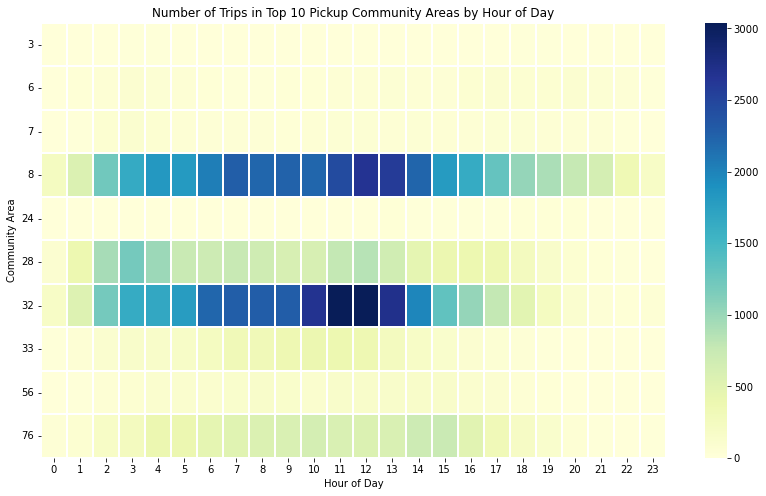

In [30]:
# Plot number of trips per hour of the day for top 10 pickup community areas
# First, we need to find the top 10 pickup community areas
top_10_pickup_areas = df['pickup_community_area'].value_counts().head(10).index

# Filter the dataframe to include only trips that start in the top 10 pickup areas
top_pickup_df = df[df['pickup_community_area'].isin(top_10_pickup_areas)]

# Group by pickup community area and hour of day, then count the number of trips
pickup_heatmap_data = top_pickup_df.groupby(['pickup_community_area', top_pickup_df.index.hour]).size().unstack(level=-1)

# Since some hours may have no trips for some areas, we fill NaNs with 0
pickup_heatmap_data = pickup_heatmap_data.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(pickup_heatmap_data, cmap='YlGnBu', linewidths=2)
plt.title('Number of Trips in Top 10 Pickup Community Areas by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Community Area')
plt.yticks(rotation=0)  
plt.show()

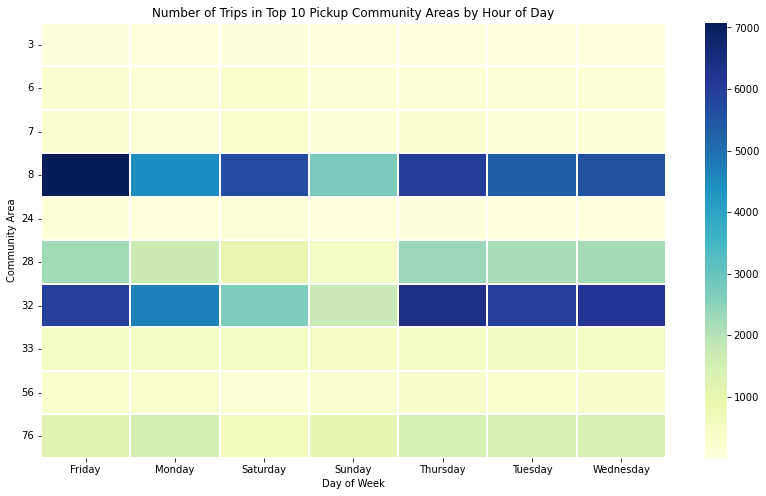

In [74]:
# Plot number of trips per hour of the day for top 10 pickup community areas
# First, we need to find the top 10 pickup community areas
top_10_pickup_areas = df['pickup_community_area'].value_counts().head(10).index

# Filter the dataframe to include only trips that start in the top 10 pickup areas
top_pickup_df = df[df['pickup_community_area'].isin(top_10_pickup_areas)]

days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
# Group by pickup community area and hour of day, then count the number of trips
pickup_heatmap_data = top_pickup_df.groupby(['pickup_community_area', top_pickup_df['day_of_week']]).size().unstack(level=-1)

# Since some hours may have no trips for some areas, we fill NaNs with 0
pickup_heatmap_data = pickup_heatmap_data.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(pickup_heatmap_data, cmap='YlGnBu', linewidths=2)
plt.title('Number of Trips in Top 10 Pickup Community Areas by Hour of Day')
plt.xlabel('Day of Week')
plt.ylabel('Community Area')
plt.yticks(rotation=0)  
plt.show()

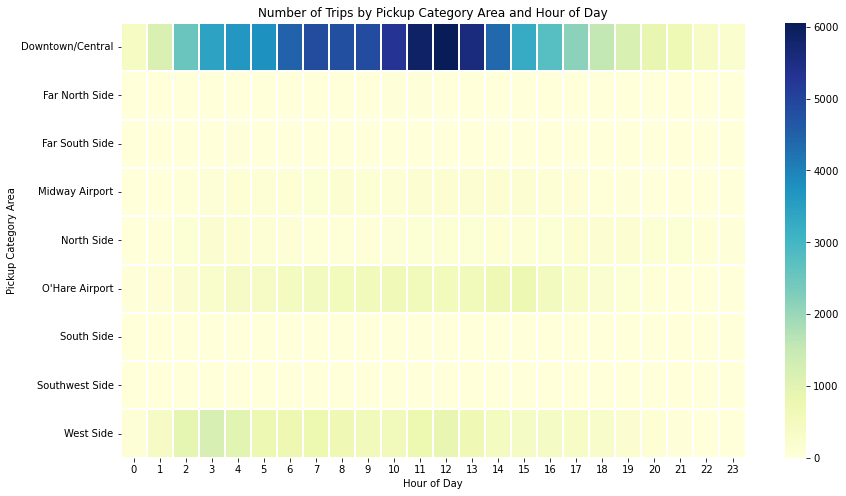

In [75]:
# Plot number of trips per hour of the day for pickup category areas
# Group by pickup category area and hour of day, then count the number of trips
pickup_category_heatmap_data = df.groupby(['pickup_category_area', df['hour_of_day']]).size().unstack(level=-1)

# Since some hours may have no trips for some categories, we fill NaNs with 0
pickup_category_heatmap_data = pickup_category_heatmap_data.fillna(0)

# Creating the heatmap for pickup category area by hour of day
plt.figure(figsize=(14, 8))
sns.heatmap(pickup_category_heatmap_data, cmap='YlGnBu', linewidths=2)
plt.title('Number of Trips by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()

### Analysis based on fares and prices

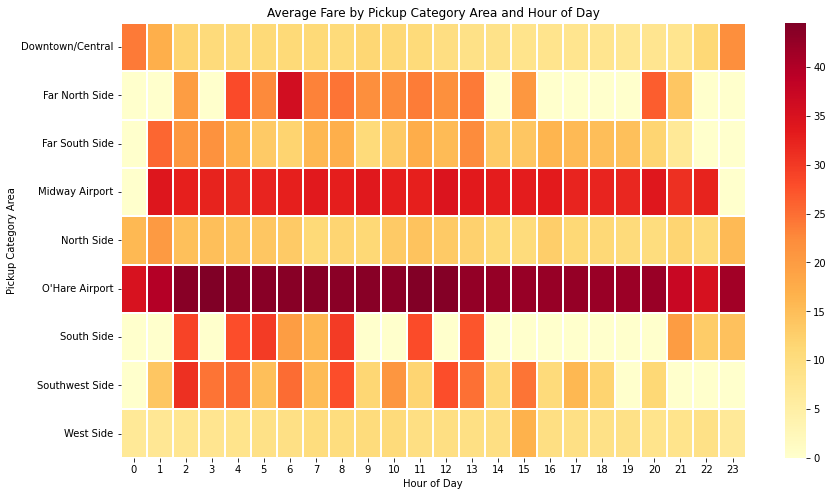

In [33]:
# Plot average fare by hour of the day and pickup category area
# Group by pickup category area and hour of day, then calculate the mean fare
avg_fare_heatmap_data = df.groupby(['pickup_category_area', df.index.hour])['fare'].mean().unstack(level=-1)

# Since some hours may have no trips for some categories, we fill NaNs with 0
avg_fare_heatmap_data = avg_fare_heatmap_data.fillna(0)

# Creating the heatmap for average fare by pickup category area and hour of day
plt.figure(figsize=(14, 8))
sns.heatmap(avg_fare_heatmap_data, cmap='YlOrRd', linewidths=2)
plt.title('Average Fare by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()

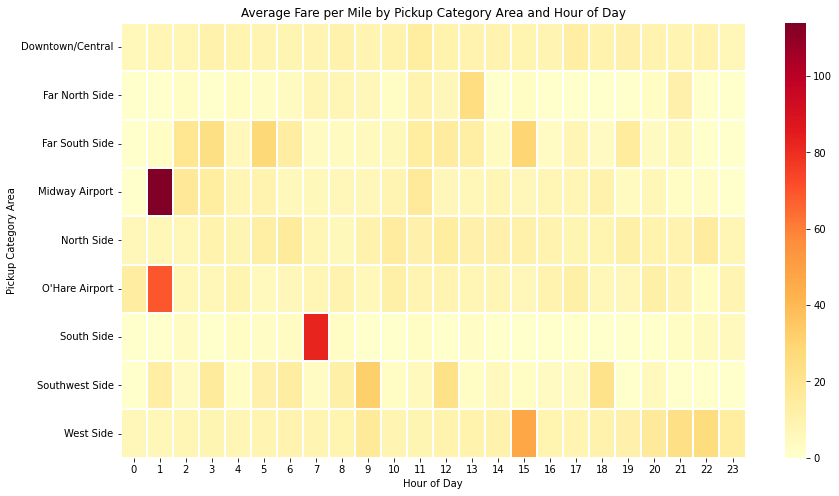

In [34]:
# Plot average fare per mile by hour of day and pickup category area
# Group by pickup category area and hour of day, then calculate the average 'fare/miles'
fare_per_mile_heatmap_data = df.groupby(['pickup_category_area', df.index.hour])['fare/miles'].mean().unstack(level=-1)

# Since some hours may have no data for some categories, we'll fill NaNs with 0
fare_per_mile_heatmap_data = fare_per_mile_heatmap_data.fillna(0)

# Creating the heatmap for fare per mile by pickup category area and hour of day
plt.figure(figsize=(14, 8))
sns.heatmap(fare_per_mile_heatmap_data, cmap='YlOrRd', linewidths=2)
plt.title('Average Fare per Mile by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()


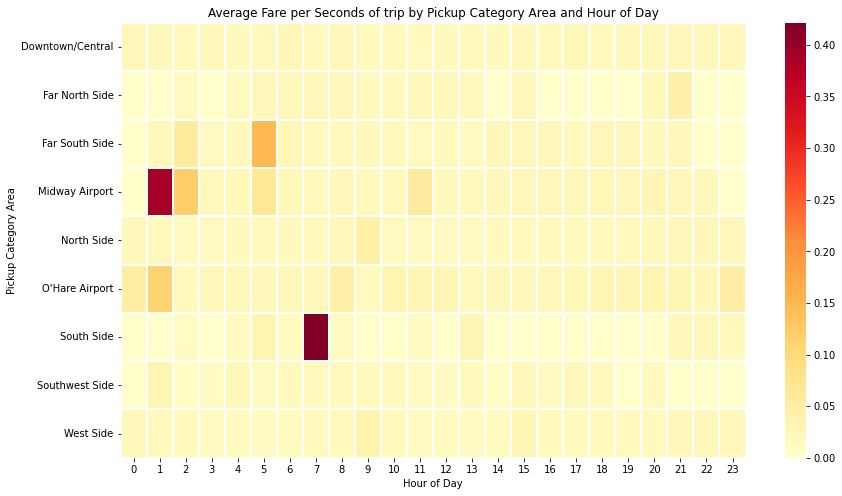

In [35]:
# Plot average fare per seconds of trip by hour of day and pickup category area
# Group by pickup category area and hour of day, then calculate the average 'fare/miles'
fare_per_mile_heatmap_data = df.groupby(['pickup_category_area', df.index.hour])['fare/seconds'].mean().unstack(level=-1)

# Since some hours may have no data for some categories, we'll fill NaNs with 0
fare_per_mile_heatmap_data = fare_per_mile_heatmap_data.fillna(0)

# Creating the heatmap for fare per mile by pickup category area and hour of day
plt.figure(figsize=(14, 8))
sns.heatmap(fare_per_mile_heatmap_data, cmap='YlOrRd', linewidths=2)
plt.title('Average Fare per Seconds of trip by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()


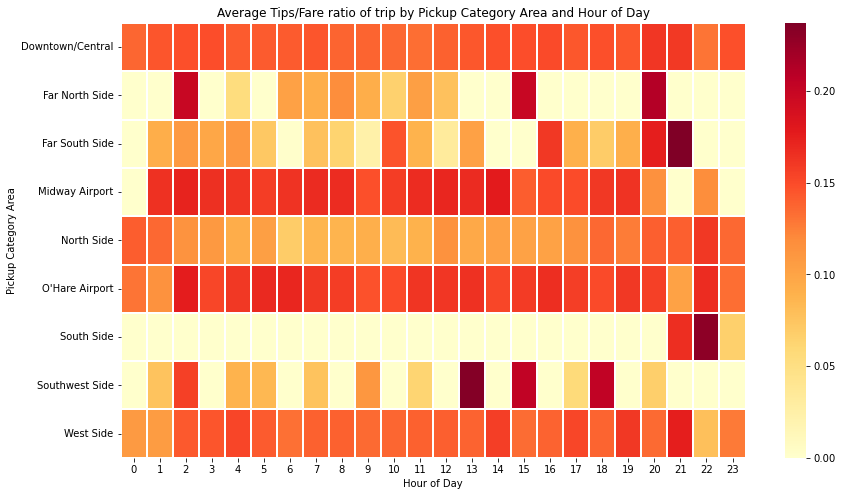

In [36]:
# Group by pickup category area and hour of day, then calculate the average 'fare/miles'
fare_per_mile_heatmap_data = df.groupby(['pickup_category_area', df.index.hour])['tips/fare'].mean().unstack(level=-1)

# Since some hours may have no data for some categories, we'll fill NaNs with 0
fare_per_mile_heatmap_data = fare_per_mile_heatmap_data.fillna(0)

# Creating the heatmap for fare per mile by pickup category area and hour of day
plt.figure(figsize=(14, 8))
sns.heatmap(fare_per_mile_heatmap_data, cmap='YlOrRd', linewidths=2)
plt.title('Average Tips/Fare ratio of trip by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()


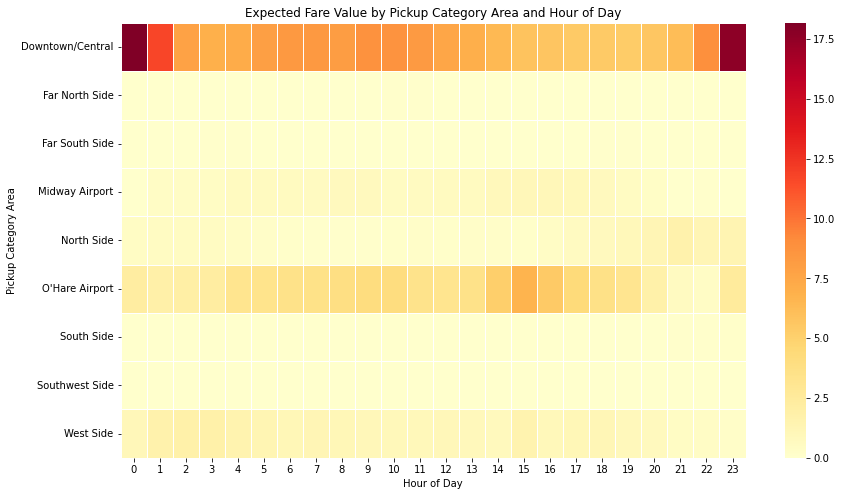

In [76]:
# Expected Values: Probability of picking up a commuter in each pickup category area for each hour of day * Average fare for trips that occur in that area and hour

# Calculate the total number of trips for each hour
total_trips_per_hour = df.groupby(df['hour_of_day']).size()

# Calculate the number of trips per pickup category area per hour
trips_per_category_area_per_hour = df.groupby(['pickup_category_area', df['hour_of_day']]).size()

# Calculate the probability of picking up a commuter in each pickup category area for each hour of day
# The probability is now based on the total trips that occur in each hour across all areas
pickup_probability = trips_per_category_area_per_hour.div(total_trips_per_hour, level=1)

# Calculate the average fare for trips that occur in that area and hour
average_fare_per_category_area_per_hour = df.groupby(['pickup_category_area', df['hour_of_day']])['fare'].mean()

# Multiply the probability by the average fare to get the expected fare value
expected_fare_value = pickup_probability.mul(average_fare_per_category_area_per_hour)

# Unstack the hour level to prepare for the heatmap
expected_fare_heatmap_data = expected_fare_value.unstack(level=-1)

# Fill NaN values with 0
expected_fare_heatmap_data = expected_fare_heatmap_data.fillna(0)

# Creating the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(expected_fare_heatmap_data, cmap='YlOrRd', linewidths=.5)
plt.title('Expected Fare Value by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()


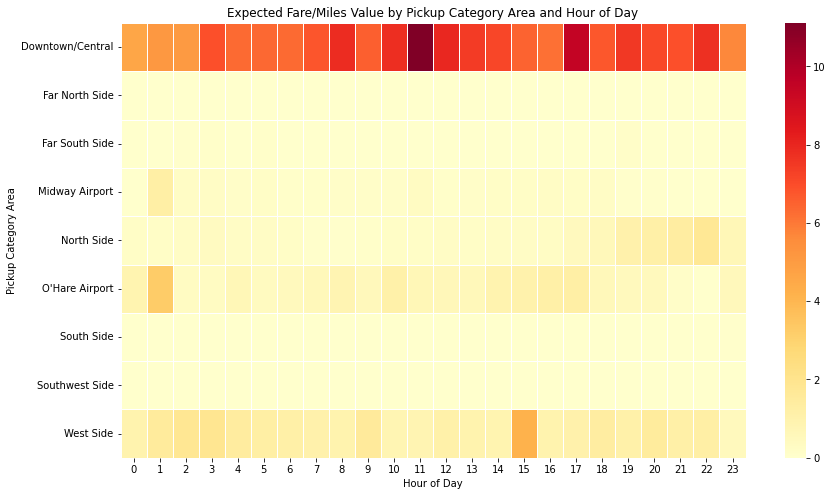

In [88]:
# Expected Values: Probability of picking up a commuter in each pickup category area for each hour of day * Average fare/miles for trips that occur in that area and hour

# Calculate the total number of trips for each hour
total_trips_per_hour = df.groupby(df['hour_of_day']).size()

# Calculate the number of trips per pickup category area per hour
trips_per_category_area_per_hour = df.groupby(['pickup_category_area', df['hour_of_day']]).size()

# Calculate the probability of picking up a commuter in each pickup category area for each hour of day
# The probability is now based on the total trips that occur in each hour across all areas
pickup_probability = trips_per_category_area_per_hour.div(total_trips_per_hour, level=1)

# Calculate the average fare for trips that occur in that area and hour
average_fare_per_category_area_per_hour = df.groupby(['pickup_category_area', df['hour_of_day']])['fare/miles'].mean()

# Multiply the probability by the average fare to get the expected fare value
expected_fare_value = pickup_probability.mul(average_fare_per_category_area_per_hour)

# Unstack the hour level to prepare for the heatmap
expected_fare_heatmap_data = expected_fare_value.unstack(level=-1)

# Fill NaN values with 0
expected_fare_heatmap_data = expected_fare_heatmap_data.fillna(0)

# Creating the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(expected_fare_heatmap_data, cmap='YlOrRd', linewidths=.5)
plt.title('Expected Fare/Miles Value by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()


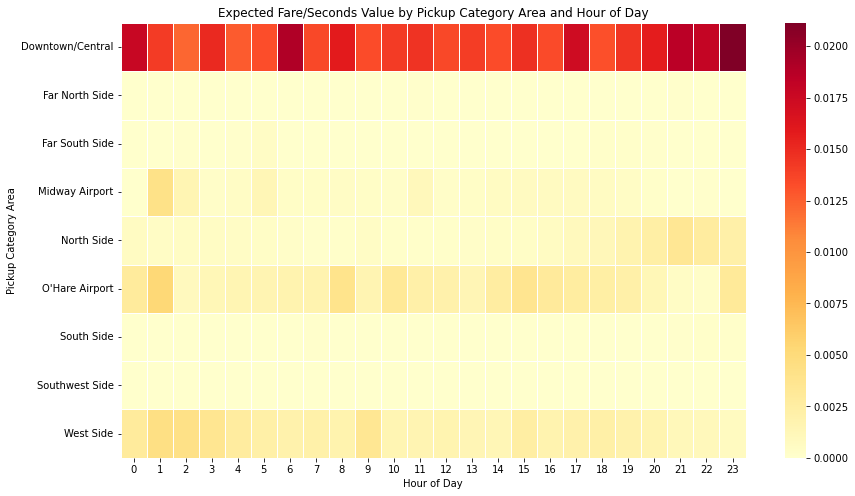

In [89]:
# Expected Values: Probability of picking up a commuter in each pickup category area for each hour of day * Average fare/seconds for trips that occur in that area and hour

# Calculate the total number of trips for each hour
total_trips_per_hour = df.groupby(df.index.hour).size()

# Calculate the number of trips per pickup category area per hour
trips_per_category_area_per_hour = df.groupby(['pickup_category_area', df['hour_of_day']]).size()

# Calculate the probability of picking up a commuter in each pickup category area for each hour of day
# The probability is now based on the total trips that occur in each hour across all areas
pickup_probability = trips_per_category_area_per_hour.div(total_trips_per_hour, level=1)

# Calculate the average fare for trips that occur in that area and hour
average_fare_per_category_area_per_hour = df.groupby(['pickup_category_area', df.index.hour])['fare/seconds'].mean()

# Multiply the probability by the average fare to get the expected fare value
expected_fare_value = pickup_probability.mul(average_fare_per_category_area_per_hour)

# Unstack the hour level to prepare for the heatmap
expected_fare_heatmap_data = expected_fare_value.unstack(level=-1)

# Fill NaN values with 0
expected_fare_heatmap_data = expected_fare_heatmap_data.fillna(0)

# Creating the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(expected_fare_heatmap_data, cmap='YlOrRd', linewidths=.5)
plt.title('Expected Fare/Seconds Value by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()


### Ultimate Tip hunting guide

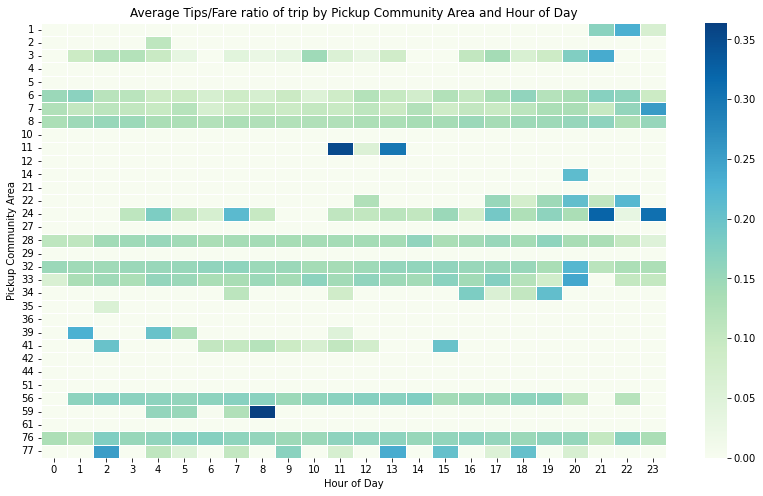

In [90]:
# Group by pickup category area and hour of day, then calculate the average 'fare/miles'
fare_per_mile_heatmap_data = df.groupby(['pickup_community_area', df['hour_of_day']])['tips/fare'].mean().unstack(level=-1)

# Since some hours may have no data for some categories, we'll fill NaNs with 0
fare_per_mile_heatmap_data = fare_per_mile_heatmap_data.fillna(0)

# Creating the heatmap for fare per mile by pickup category area and hour of day
plt.figure(figsize=(14, 8))
sns.heatmap(fare_per_mile_heatmap_data, cmap='GnBu', linewidths=.5)
plt.title('Average Tips/Fare ratio of trip by Pickup Community Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Community Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()


### Company comparison

In [41]:
df_company = df.groupby('company').sum().sort_values(by='fare', ascending=False).head(40)
# For the rest of the company KPI analysis, we will focus on the top 40 companies by earnings in fare

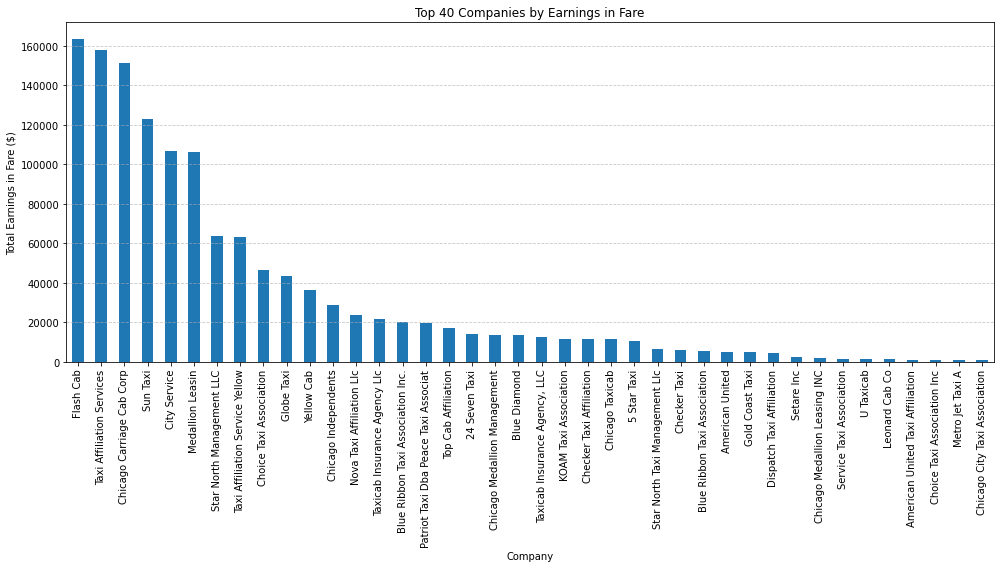

In [42]:
# Plot the top 40 companies by earnings in fare
earning = df_company['fare']

plt.figure(figsize=(14, 8))
earning.plot(kind='bar')
plt.title('Top 40 Companies by Earnings in Fare')
plt.xlabel('Company')
plt.ylabel('Total Earnings in Fare ($)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

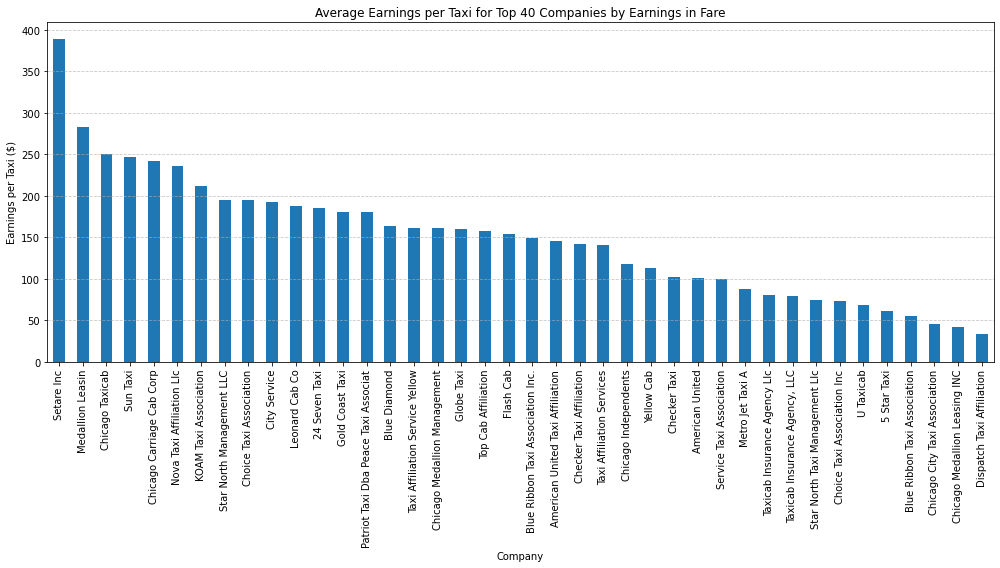

In [107]:
# Replica
# Companies ranked based on their earnings per taxis they have (Among top 40 earners)
# Subject to inaccuracy as we taxi medalions change hands and one taxi medalion can be used by multiple companies in different times

# First, we will calculate the total fare earnings per company
total_fares = df.groupby('company')['fare'].sum()

# Then, count the number of unique taxis per company using the 'taxi_id_int' column
unique_taxis = df.groupby('company')['taxi_id_int'].nunique()

# Now, we calculate earnings per taxi for each company
earnings_per_taxi = total_fares / unique_taxis

# We will only consider the top companies by total fare
top_companies_by_fare = total_fares.sort_values(ascending=False).head(40).index
top_earnings_per_taxi = earnings_per_taxi.loc[top_companies_by_fare].sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(14, 8))
top_earnings_per_taxi.plot(kind='bar')
plt.title('Average Earnings per Taxi for Top 40 Companies by Earnings in Fare')
plt.xlabel('Company')
plt.ylabel('Earnings per Taxi ($)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


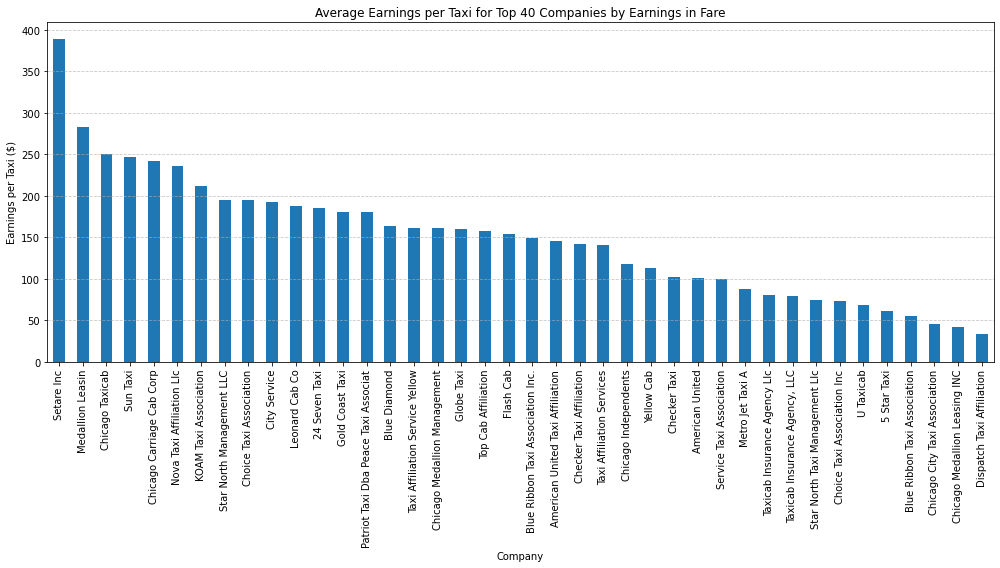

In [106]:
#Original
# Companies ranked based on their earnings per taxis they have (Among top 40 earners)
# Subject to inaccuracy as we taxi medalions change hands and one taxi medalion can be used by multiple companies in different times

# First, we will calculate the total fare earnings per company
total_fares = df.groupby('company')['fare'].sum()

# Then, count the number of unique taxis per company using the 'taxi_id_int' column
unique_taxis = df.groupby('company')['taxi_id_int'].nunique()

# Now, we calculate earnings per taxi for each company
earnings_per_taxi = total_fares / unique_taxis

# We will only consider the top companies by total fare
top_companies_by_fare = total_fares.sort_values(ascending=False).head(40).index
top_earnings_per_taxi = earnings_per_taxi.loc[top_companies_by_fare].sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(14, 8))
top_earnings_per_taxi.plot(kind='bar')
plt.title('Average Earnings per Taxi for Top 40 Companies by Earnings in Fare')
plt.xlabel('Company')
plt.ylabel('Earnings per Taxi ($)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


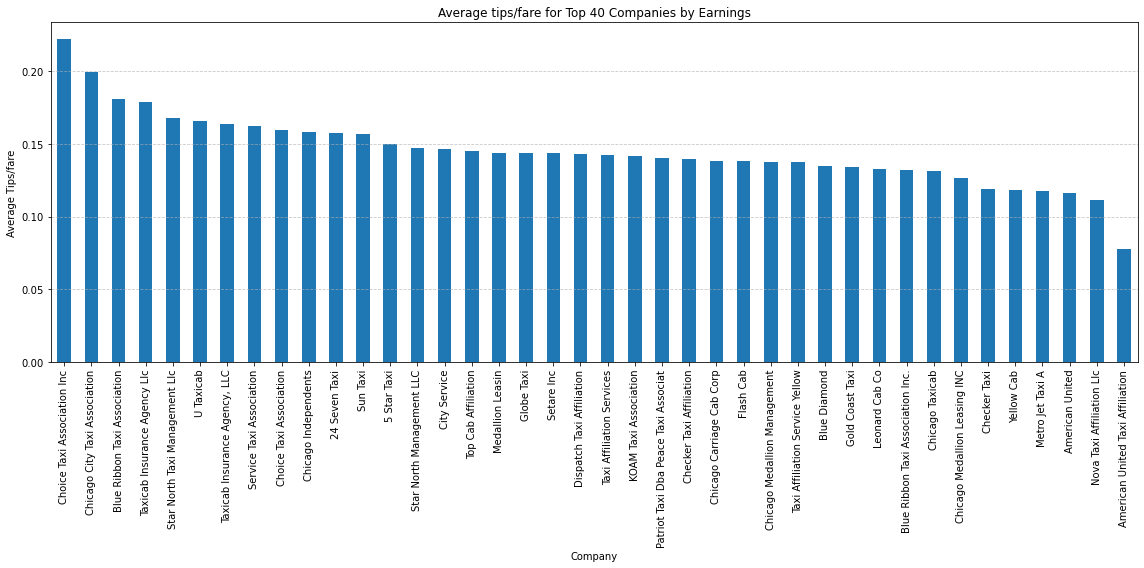

In [136]:
# Plot companies earning per numer of trips they have (Among top 40 earners)


tips_per_fare = df.groupby('company')['tips/fare'].mean().sort_values(ascending=False)
top_earnings = df.groupby('company').sum().sort_values(by='fare', ascending=False).head(40)
tips_per_fare.loc[top_earnings.index].sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
sorted_average_fare_per_trip_top_40.plot(kind='bar')
plt.title('Average tips/fare for Top 40 Companies by Earnings')
plt.xlabel('Company')
plt.ylabel('Average Tips/fare')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


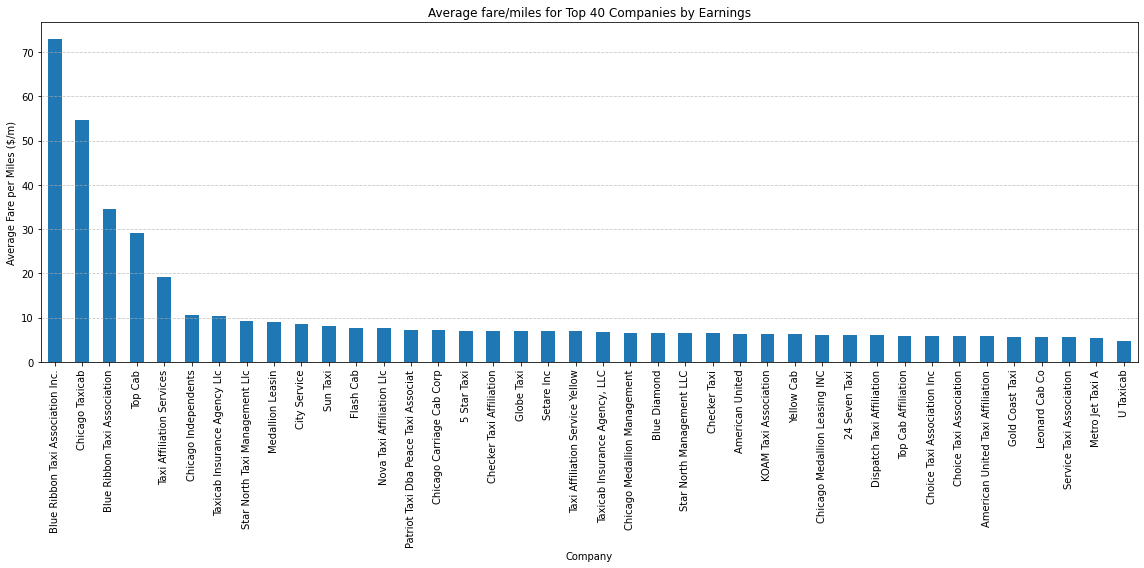

In [44]:
# Plot companies earning per numer of trips they have (Among top 40 earners)
# Calculate total fares and total number of trips per company
total_fares = df.groupby('company')['fare/miles'].sum()
total_trips = df.groupby('company').size()

# Get the top 40 companies by total fare earnings
top_40_companies_by_fare = total_fares.sort_values(ascending=False).head(40).index

# Filter the total fares and total trips for the top 40 companies
top_40_total_fares = total_fares.loc[top_40_companies_by_fare]
top_40_total_trips = total_trips.loc[top_40_companies_by_fare]

# Calculate the average fare per trip for the top 40 companies
average_fare_per_trip_top_40 = top_40_total_fares / top_40_total_trips

# Sort the companies by average fare per trip
sorted_average_fare_per_trip_top_40 = average_fare_per_trip_top_40.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
sorted_average_fare_per_trip_top_40.plot(kind='bar')
plt.title('Average fare/miles for Top 40 Companies by Earnings')
plt.xlabel('Company')
plt.ylabel('Average Fare per Miles ($/m)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


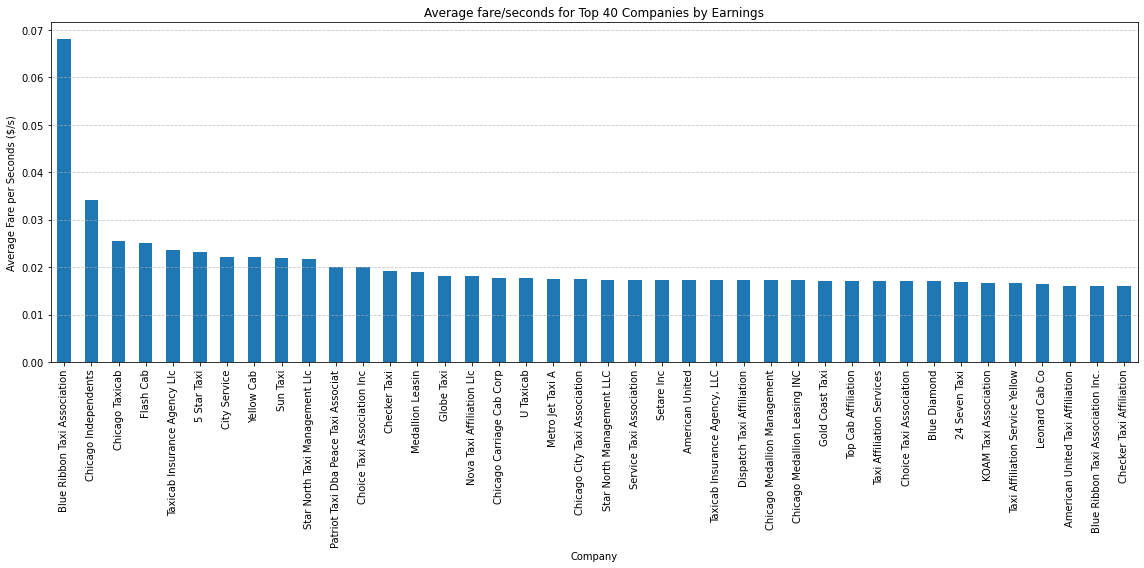

In [45]:
# Plot companies earning per numer of trips they have (Among top 40 earners)
# Calculate total fares and total number of trips per company
total_fares = df.groupby('company')['fare/seconds'].sum()
total_trips = df.groupby('company').size()

# Get the top 40 companies by total fare earnings
top_40_companies_by_fare = total_fares.sort_values(ascending=False).head(40).index

# Filter the total fares and total trips for the top 40 companies
top_40_total_fares = total_fares.loc[top_40_companies_by_fare]
top_40_total_trips = total_trips.loc[top_40_companies_by_fare]

# Calculate the average fare per trip for the top 40 companies
average_fare_per_trip_top_40 = top_40_total_fares / top_40_total_trips

# Sort the companies by average fare per trip
sorted_average_fare_per_trip_top_40 = average_fare_per_trip_top_40.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
sorted_average_fare_per_trip_top_40.plot(kind='bar')
plt.title('Average fare/seconds for Top 40 Companies by Earnings')
plt.xlabel('Company')
plt.ylabel('Average Fare per Seconds ($/s)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


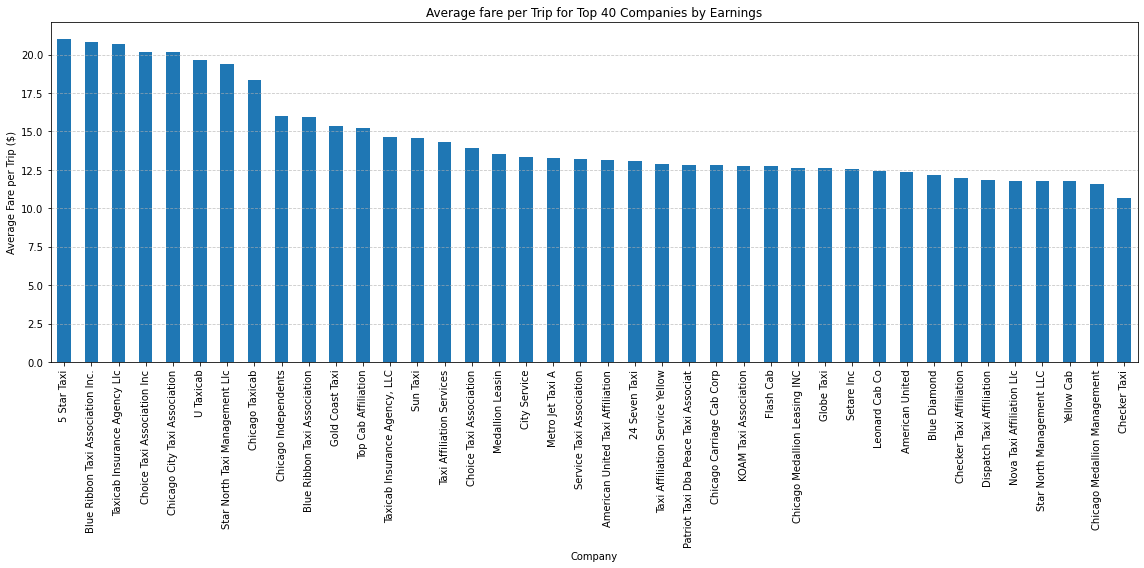

In [46]:
# Plot companies earning per numer of trips they have (Among top 40 earners)
# Calculate total fares and total number of trips per company
total_fares = df.groupby('company')['fare'].sum()
total_trips = df.groupby('company').size()

# Get the top 40 companies by total fare earnings
top_40_companies_by_fare = total_fares.sort_values(ascending=False).head(40).index

# Filter the total fares and total trips for the top 40 companies
top_40_total_fares = total_fares.loc[top_40_companies_by_fare]
top_40_total_trips = total_trips.loc[top_40_companies_by_fare]

# Calculate the average fare per trip for the top 40 companies
average_fare_per_trip_top_40 = top_40_total_fares / top_40_total_trips

# Sort the companies by average fare per trip
sorted_average_fare_per_trip_top_40 = average_fare_per_trip_top_40.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
sorted_average_fare_per_trip_top_40.plot(kind='bar')
plt.title('Average fare per Trip for Top 40 Companies by Earnings')
plt.xlabel('Company')
plt.ylabel('Average Fare per Trip ($)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Some distribution plots to put the numbers in Statistical Analysis into the context

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_series_without_outliers(series, title, bins=50):

    """
    Plot the distribution of a pandas Series excluding outliers.
    
    :param series: pandas Series containing the data to plot
    :param whisker_width: the multiplier for IQR to determine outliers (default is 3)
    """
    whisker_width = 3
    # Calculate Q1, Q3 and IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - whisker_width * IQR
    upper_bound = Q3 + whisker_width * IQR
    
    # Remove outliers
    filtered_series = series[(series >= lower_bound) & (series <= upper_bound)]
    
    # Plot the distribution of the non-outlier values
    plt.figure(figsize=(10, 6))
    filtered_series.hist(bins=bins, edgecolor='k')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(False)
    plt.show()

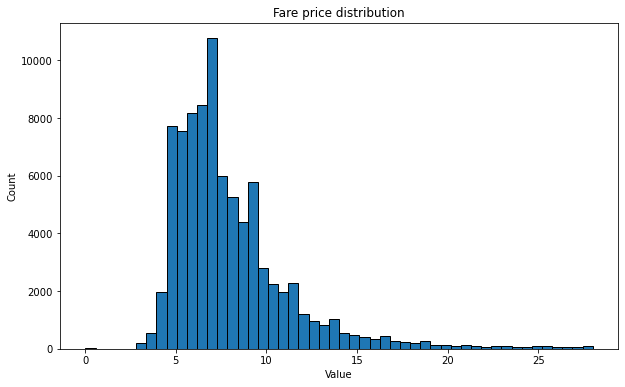

In [49]:
plot_series_without_outliers(df['fare'], 'Fare price distribution')

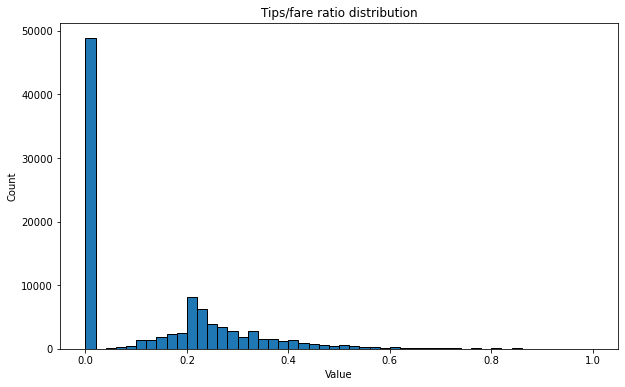

In [50]:
plot_series_without_outliers(df['tips/fare'], 'Tips/fare ratio distribution')

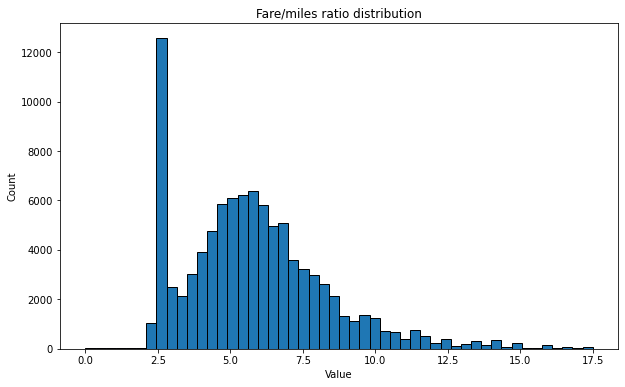

In [51]:
plot_series_without_outliers(df['fare/miles'], 'Fare/miles ratio distribution')

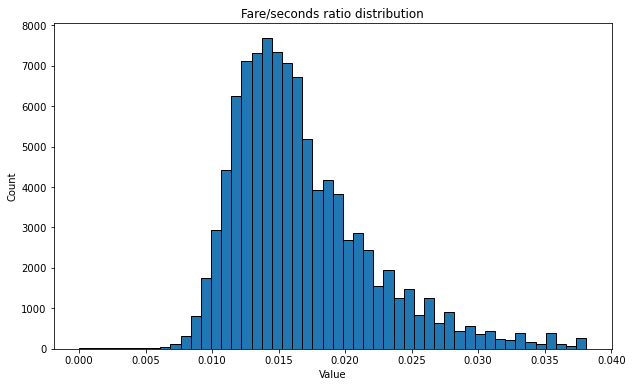

In [52]:
plot_series_without_outliers(df['fare/seconds'], 'Fare/seconds ratio distribution')

In [53]:
# Plot average fare per mile by hour of day and pickup category area
# Group by pickup category area and hour of day, then calculate the average 'fare/miles'
fare_per_mile_heatmap_data = df.groupby(['pickup_category_area', df.index.hour])['fare/miles'].mean().unstack(level=-1)

# Since some hours may have no data for some categories, we'll fill NaNs with 0
fare_per_mile_heatmap_data = fare_per_mile_heatmap_data.fillna(0)



In [54]:
fare_per_mile_heatmap_data.index

Index(['Downtown/Central', 'Far North Side', 'Far South Side',
       'Midway Airport', 'North Side', 'O'Hare Airport', 'South Side',
       'Southwest Side', 'West Side'],
      dtype='object', name='pickup_category_area')

In [55]:
Q1 = fare_per_mile_heatmap_data.quantile(0.25)
Q3 = fare_per_mile_heatmap_data.quantile(0.75)
IQR = Q3 - Q1

In [56]:
ww = 5
df_filtered  = fare_per_mile_heatmap_data[~((fare_per_mile_heatmap_data < (Q1 - ww * IQR)) | (fare_per_mile_heatmap_data > (Q3 + ww * IQR))).any(axis=1)]

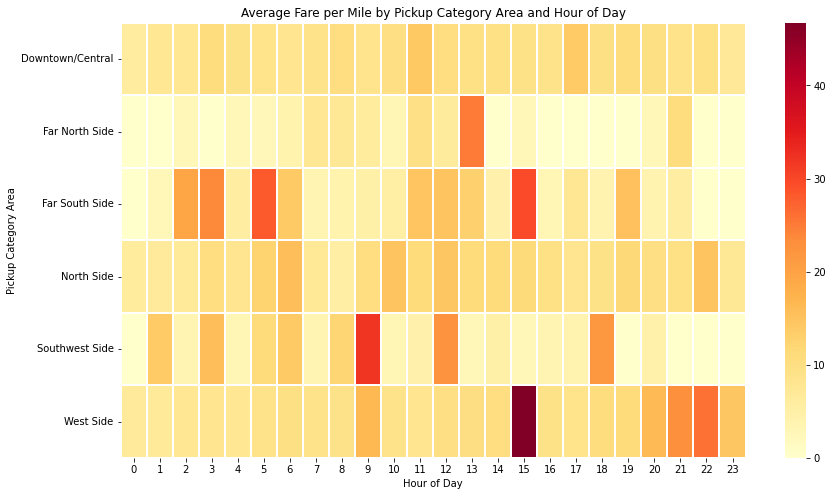

In [57]:
# Creating the heatmap for fare per mile by pickup category area and hour of day
plt.figure(figsize=(14, 8))
sns.heatmap(df_filtered  , cmap='YlOrRd', linewidths=2)
plt.title('Average Fare per Mile by Pickup Category Area and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Category Area')
plt.yticks(rotation=0)  # Keep the pickup category area labels horizontal for readability
plt.show()

### Statistical Tests

In [58]:
sample_mean = df['fare'].mean()
sample_std= df['fare'].std()
sample_size = len(df)

In [59]:
from scipy import stats

In [60]:
z_score = stats.norm.ppf(0.975)# Two-tailed (for 95%: 1 - (1 - 0.95)/2)

In [61]:
margin_of_error = z_score * (sample_std / np.sqrt(sample_size))

In [62]:
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

print(f"95% Confidence interval: {confidence_interval}")

95% Confidence interval: (13.37805706078663, 13.61313673921338)
